In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.pandas import DataFrame 

from pyspark.mllib.stat import KernelDensity
from pyspark.ml.linalg import Vectors

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

/usr/lib/spark/spark-3.3.3-bin-hadoop3/python/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
spark = SparkSession.builder\
	.master("local[*]").appName("Statistical_Analysis").getOrCreate()

24/09/03 22:15:49 WARN Utils: Your hostname, abraham resolves to a loopback address: 127.0.1.1; using 192.168.0.145 instead (on interface eno2)
24/09/03 22:15:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/09/03 22:15:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file_path = "/user/ids_analysis/UNSW-NB15.csv"
data = spark.read.csv(file_path, inferSchema=True)
data = data.toDF(
    'srcip',
    'sport',
    'dstip',
    'dsport',
    'proto',
    'state',
    'dur',
    'sbytes',
    'dbytes',
    'sttl',
    'dttl',
    'sloss',
    'dloss',
    'service',
    'Sload',
    'Dload',
    'Spkts',
    'Dpkts',
    'swin',
    'dwin',
    'stcpb',
    'dtcpb',
    'smeansz',
    'dmeansz',
    'trans_depth',
    'res_bdy_len',
    'Sjit',
    'Djit',
    'Stime',
    'Ltime',
    'Sintpkt',
    'Dintpkt',
    'tcprtt',
    'synack',
    'ackdat',
    'is_sm_ips_ports',
    'ct_state_ttl',
    'ct_flw_http_mthd',
    'is_ftp_login',
    'ct_ftp_cmd',
    'ct_srv_src',
    'ct_srv_dst',
    'ct_dst_ltm',
    'ct_src_ ltm',
    'ct_src_dport_ltm',
    'ct_dst_sport_ltm',
    'ct_dst_src_ltm',
    'attack_cat',
    'Label'
)

In [4]:
clean_data = data.withColumn("attack_cat", regexp_replace("attack_cat", "Shellcode ", "Shellcode"))
clean_data = clean_data.withColumn("attack_cat", regexp_replace("attack_cat", "Reconnaissance ", "Reconnaissance"))
clean_data = clean_data.withColumn("attack_cat", regexp_replace("attack_cat", "Fuzzers ", "Fuzzers"))


#### Descriptive Statistics

In [5]:
# Descriptive statistics on numeric columns
clean_data.select("dur", "sbytes", "dbytes", "smeanSz", "dmeanSz").describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+
|summary|               dur|           sbytes|            dbytes|           smeanSz|           dmeanSz|
+-------+------------------+-----------------+------------------+------------------+------------------+
|  count|           2539739|          2539739|           2539739|           2539739|           2539739|
|   mean|0.6588634003798671|4340.072263330996| 36432.01132478574|124.25270588828222|276.70543193611627|
| stddev|13.925767633289526|56409.39812286229|161105.30400824704|151.92108772283441|  335.623165013593|
|    min|               0.0|                0|                 0|                 0|                 0|
|    max|         8786.6377|         14355774|          14657531|              1504|              1500|
+-------+------------------+-----------------+------------------+------------------+------------------+



#### Correlation Analysis

Correlation between Source Bytes and Destination Bytes: 0.047025532784903006


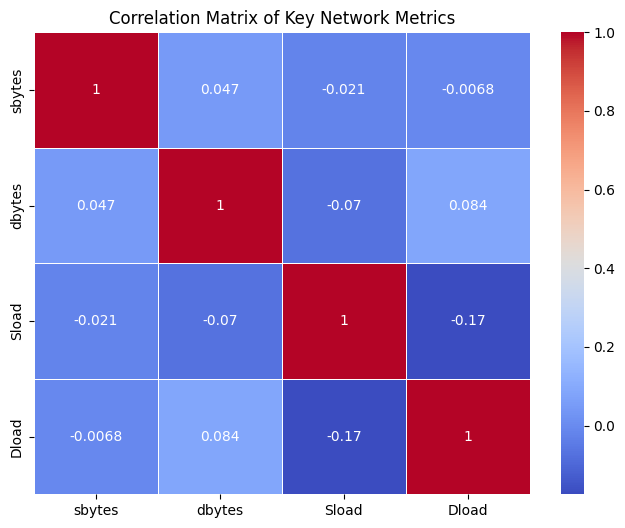

In [6]:
# Compute correlation between 'sbytes' and 'dbytes' (Source and Destination Bytes)
corr_sbytes_dbytes = clean_data.stat.corr("sbytes", "dbytes")
print(f"Correlation between Source Bytes and Destination Bytes: {corr_sbytes_dbytes}")

# Create a correlation matrix for key variables
variables = ["sbytes", "dbytes", "Sload", "Dload"]
corr_matrix = {}

for col1 in variables:
    corr_matrix[col1] = []
    for col2 in variables:
        corr_value = clean_data.stat.corr(col1, col2)
        corr_matrix[col1].append(corr_value)


# Create a pandas DataFrame from the correlation matrix
corr_df = pd.DataFrame(corr_matrix, index=variables, columns=variables)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of Key Network Metrics')
plt.show()

#### Hypothesis Testing (Chi-Square Test for Categorical Variables)

In [7]:
# Drop rows with NULL values in 'attack_cat' and 'proto' columns
df_cleaned = clean_data.na.drop(subset=["attack_cat", "proto"])

# Convert categorical variables to numeric using StringIndexer
indexer_attack_cat = StringIndexer(inputCol="attack_cat", outputCol="attack_cat_index")
df_indexed = indexer_attack_cat.fit(df_cleaned).transform(df_cleaned)

indexer_proto = StringIndexer(inputCol="proto", outputCol="proto_index")
df_indexed = indexer_proto.fit(df_indexed).transform(df_indexed)

# Assemble 'proto_index' into a vector (Chi-Square test expects features as vectors)
assembler = VectorAssembler(inputCols=["proto_index"], outputCol="features")
df_vector = assembler.transform(df_indexed)

# Perform Chi-Square test on 'attack_cat_index' and 'proto_index'
chi_square_result = ChiSquareTest.test(df_vector, "features", "attack_cat_index").head()

# Display the results
print(f"P-values: {chi_square_result.pValues}")
print(f"Degrees of freedom: {chi_square_result.degreesOfFreedom}")
print(f"Statistics: {chi_square_result.statistics}")

P-values: [0.0]
Degrees of freedom: [1152]
Statistics: [313698.490184459]


##### Visualization of Attack and Protocol Relationships

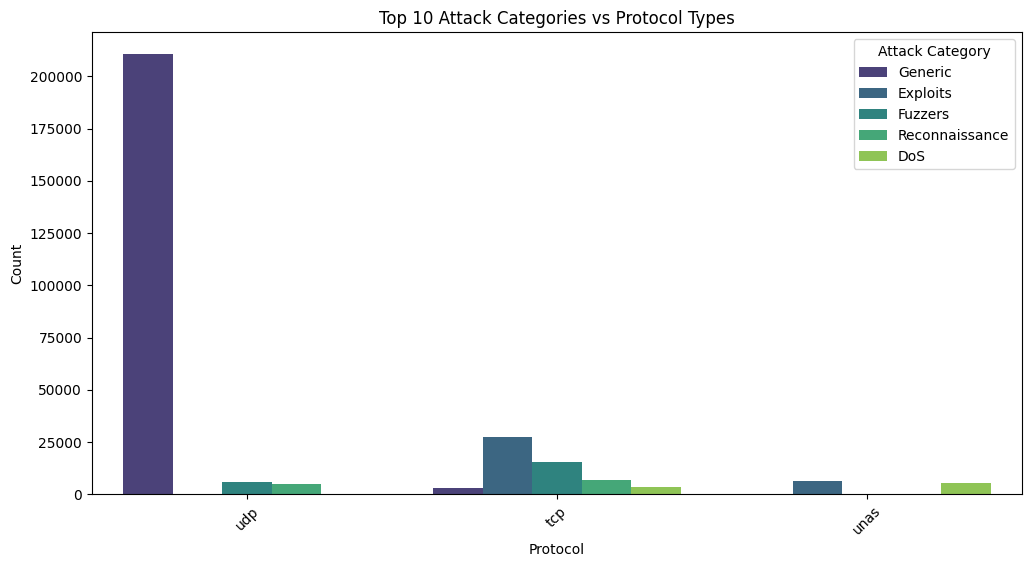

In [8]:
# Convert the relevant columns into pandas DataFrame for easier manipulation and plotting
df_pd = df_indexed.select("attack_cat", "proto").toPandas()

# Create a contingency table and count occurrences
contingency_table = pd.crosstab(df_pd['attack_cat'], df_pd['proto'])

# Convert contingency table to a long format for easier sorting
contingency_long = contingency_table.stack().reset_index()
contingency_long.columns = ['attack_cat', 'proto', 'count']

# Filter for the top N relations (e.g., top 10 most frequent combinations)
top_n = 10
top_relations = contingency_long.sort_values(by='count', ascending=False).head(top_n)

# Plot the top relations using a barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_relations, x='proto', y='count', hue='attack_cat', palette='viridis')
plt.title(f"Top {top_n} Attack Categories vs Protocol Types")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Attack Category")
plt.show()

#### Density Estimation (Kernel Density Estimation)

In [56]:
data_list = clean_data.select("sload").rdd.map(lambda row: row[0]).filter(lambda x: x is not None).sample(False, 0.0001).collect()

kd = KernelDensity()
sample = spark._sc.parallelize(data_list)
kd.setSample(sample)
kd.setBandwidth(3.0)
densities = kd.estimate(data_list)



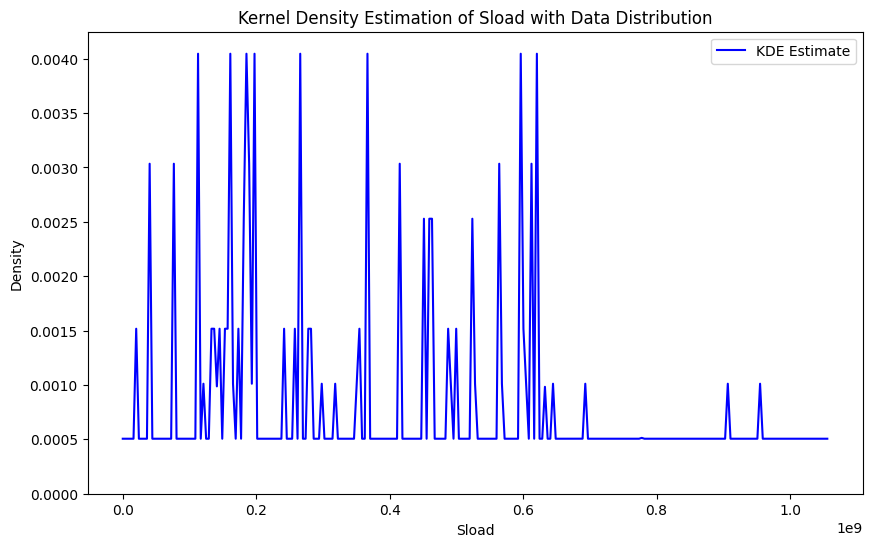

In [57]:
# Step 1: Plot histogram of the sampled data points
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=30, density=True, alpha=0.5)

# Step 2: Plot KDE as a line over the histogram
# 'x_values' represent the range of values for which we estimate the density
x_values = np.linspace(min(data_list), max(data_list), len(data_list))

# Plot the KDE estimations
plt.plot(x_values, densities, label='KDE Estimate', color='blue')

# Step 3: Add titles and labels
plt.title('Kernel Density Estimation of Sload with Data Distribution')
plt.xlabel('Sload')
plt.ylabel('Density')

# Step 4: Add a legend
plt.legend()

# Show the plot
plt.show()